<a href="https://www.kaggle.com/code/chris36/icr-analysis-python?scriptVersionId=138567005" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# ICR - Analysis

# Import the libraries

In [1]:
#import tensorflow as tf
#import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
from sklearn import linear_model

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier


In [2]:
#print("TensorFlow v" + tf.__version__)
#print("TensorFlow Decision Forests v" + tfdf.__version__)

# Load the Dataset

In [3]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
print(f"Full train dataset shape is {dataset_df.shape}")

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [4]:
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [5]:
#dataset_df.info()

## Pie chart for label column: Class

<Axes: ylabel='Class'>

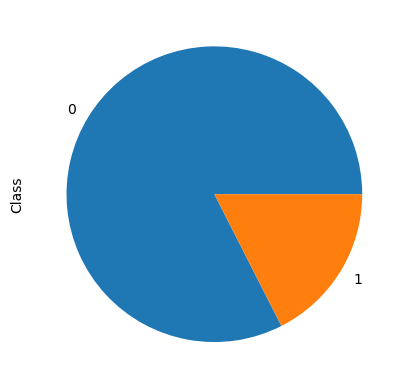

In [6]:
plot_df = dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

Dataset is imbalanced ! let's solve this 

Class Weighting 

In [7]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = total / (neg * 2.0)
weight_for_1 = total / (pos *  2.0) 

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


 data splitting 

In [8]:
dataset_df.isna().mean().mean()

0.0036606494159727265

There are some NA's in dataset. Let's impute it. 

What is the proportion of NAs in datatset ?

In [9]:
# check proportion of NA's
dataset_df = dataset_df.fillna(0.01)
print(f"The proportion of NAs is : {dataset_df.isna().mean().mean()}\n")

The proportion of NAs is : 0.0



In [10]:
# head dataset 
dataset_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [11]:
# scale data
# select var
num_var = [var for var in dataset_df.columns if var not in ["Id","EJ","Class"]]

# scale X 
#from sklearn import preprocessing
#scaler = preprocessing.StandardScaler().fit(train[num_var]) # scaler
#scaled_var = scaler.transform(train[num_var])



# replace num var with scaled values 
#dataset_df[num_var] = pd.DataFrame(scaled_var)


In [12]:
from sklearn.model_selection import train_test_split
y = dataset_df["Class"]
train0, test = train_test_split(dataset_df,test_size = 0.2,
                                stratify=dataset_df.Class, random_state=42)
train, valid = train_test_split(train0,test_size = 0.2,
                                stratify=train0.Class, random_state=42)

#  Model testing  

In [13]:
#### logistic regression
#num_var = [var for var in dataset_df.columns if var not in ["Id","EJ","Class"]]
#X_train = train0[num_var]
#y_train0 = train0.Class
#
# scale X 
#from sklearn import preprocessing
#scaler = preprocessing.StandardScaler().fit(X_train) # scaler
#X_train_scaled = scaler.transform(X_train)

In [14]:
# logistic regression 
from sklearn.linear_model import LogisticRegression
#regClf = LogisticRegression(random_state=42,
                            # class_weight ='balanced',
                            # multi_class = 'auto',
                            # max_iter= 100000)
#regClfModel = regClf.fit(X_train_scaled, y_train0)
 

In [15]:
# ridge 
from sklearn.linear_model import RidgeClassifier
ridgeClf = RidgeClassifier(alpha = 0.1,
                                random_state=42,
                               class_weight ='balanced',
                           max_iter= 1000
                                )

In [16]:
# ridgeCV
from sklearn import linear_model
ridgeCV = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13),cv = 5)

In [17]:
from sklearn.ensemble import RandomForestClassifier
Rf = RandomForestClassifier(n_estimators=100)

In [18]:
DTclf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,
     random_state=0)
#scores = cross_val_score(clf, X, y, cv=5)
#scores.mean()


In [19]:
# extra tree classifier 
XTclf = ExtraTreesClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)
 #scores = cross_val_score(clf, X, y, cv=5)


In [20]:
# Histogram based Gradient Boosting Classifier
from sklearn.ensemble import HistGradientBoostingClassifier

hbGbclf = HistGradientBoostingClassifier(max_iter=1000,learning_rate = 0.01)

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagCl = BaggingClassifier(HistGradientBoostingClassifier())
                          

In [22]:
from sklearn.ensemble import AdaBoostClassifier

adaClf = AdaBoostClassifier(n_estimators=1000)

In [23]:
# gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)

In [24]:
# svr
svc = make_pipeline(StandardScaler(),
                         SVC( random_state=42,
                                  class_weight = class_weight,probability =True))
#make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [25]:
# voting classifier 
estimators=[("XTclf", XTclf),('rf', Rf), ('DTclf', DTclf),('svc',svc)]
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators = estimators ,
     voting='soft')


In [26]:
# stacked classifier 
estimators = estimators
sclf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
 )


In [27]:
# model dictionary
model_dict = {#"regClf": regClf,
              "ridge": ridgeClf,
             # "ridgeCV": ridgeCV,
    # average meodels 
              "Rf": Rf,
              "DTclf": DTclf,
              "XTclf": XTclf,
              "bagCl": bagCl,
    # boosting models 
             "adaClf": adaClf,
            "gbCl": gbclf ,
            "hbGbclf" : hbGbclf,
    # voting classifier
            "vclf" : vclf,
    # stacked (generalization ) classifier
            "sclf" : sclf
        }

In [28]:
# function to fit models 
def fitModel(model_dict:dict,train_data,y_train,cv: int):
    scores = {}
    for model in model_dict :
        fit =model_dict[model].fit(train_data,y_train)
        #fit = make_pipeline(preprocessing.StandardScaler(), model_dict[model])
        perf0 = cross_val_score(fit,train_data,y_train,scoring='balanced_accuracy',cv= cv).mean()
        scores[model] = perf0
        #print(f"{model}_score : {round(perf0,2) }")
    perf_df = (pd.DataFrame(data = scores.values(), index = scores.keys(), columns = ["perf"])
        .sort_values(by="perf",ascending = True)
        )
    print("\n")
    return perf_df


In [29]:
# import pipeline 
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

# evaluate models 
perf = fitModel(model_dict=model_dict,train_data = train0[num_var],y_train = train0["Class"],cv = 5)
perf

,perf
XTclf,0.724664
Rf,0.759304
DTclf,0.766130
bagCl,0.798272
adaClf,0.807724
vclf,0.808557
gbCl,0.809250
ridge,0.821289
sclf,0.847875
hbGbclf,0.853110


# Model selection and evaluation   

In [30]:
#?BaggingClassifier

In [31]:
#valid score : pick a model with hp tune : TO DO 
# tune hp
model_dict2 = {"hbGbclf": hbGbclf,"bagCl" : bagCl }


In [32]:
perf2 = fitModel(model_dict = model_dict2,train_data = train0[num_var],y_train = train0["Class"],cv=5)
perf2

,perf
bagCl,0.78717
hbGbclf,0.85311


Let's pick the 2 bests algo : bagging model and stacked classifier and let's fine tune it or it input algo (histogram based gradient boosting for bagging method)

# Model selection and evaluation  

## Hyper params tuning 

In [33]:
# get estimators param
hbg_params0 = HistGradientBoostingClassifier.get_params(hbGbclf)

hbg_params0

{'categorical_features': None,
 'class_weight': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_iter': 1000,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [34]:
# histogram based gradient boosting params updated
hbg_params = {"learning_rate":[0.001,0.1,1],
    "max_iter":[1000],
    "max_leaf_nodes":[31],
    "max_depth":[3],
    "min_samples_leaf":[10,20],
    "l2_regularization":[0.0],
    "max_bins":[255],
    #"categorical_features":"Class",
   # "monotonic_cst":None,
   # "interaction_cst":None,
   # "warm_start":False,
    "early_stopping":['auto'],
    "scoring":['log_loss'],
    "validation_fraction":[0.2],
    "n_iter_no_change":[10],
    "tol":[1e-07],
    "verbose":[0],
    "random_state":[42],
    "class_weight":['balanced']
            }
                  

In [35]:
#bag params 
bag_params0 = BaggingClassifier(HistGradientBoostingClassifier()).get_params(gbclf)
bag_params0 

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__categorical_features': None,
 'estimator__class_weight': None,
 'estimator__early_stopping': 'auto',
 'estimator__interaction_cst': None,
 'estimator__l2_regularization': 0.0,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'log_loss',
 'estimator__max_bins': 255,
 'estimator__max_depth': None,
 'estimator__max_iter': 100,
 'estimator__max_leaf_nodes': 31,
 'estimator__min_samples_leaf': 20,
 'estimator__monotonic_cst': None,
 'estimator__n_iter_no_change': 10,
 'estimator__random_state': None,
 'estimator__scoring': 'loss',
 'estimator__tol': 1e-07,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': HistGradientBoostingClassifier(),
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [36]:
# bagging classifier 
bag_params = {
    "n_estimators":[100],
    "max_samples":[1.0],
    "max_features":[0.5],
    "bootstrap":[True],
    "bootstrap_features":[False],
    "oob_score":[False],
    "warm_start":[False],
    "n_jobs":[None],
    "random_state":[None],
    "verbose":[0],
    "estimator__learning_rate":[00.1,0.1,1]
    }
       
#bag_params0

In [37]:
# model performance 
# grid random search 
from sklearn.model_selection import RandomizedSearchCV
hb = RandomizedSearchCV(hbGbclf, hbg_params,scoring= "neg_log_loss",random_state=42)
#bag = RandomizedSearchCV(bagCl,bag_params,scoring= "neg_log_loss",random_state=42)

model_dict3 = {
"hb":hb,
#"bag":bag
}

## model evaluation 

In [38]:
# models perf 
perf = fitModel(model_dict = model_dict3,train_data = train0[num_var],y_train = train0["Class"],cv=5)
perf

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/

,perf
hb,0.878246


## model validation 

In [39]:
# select model 
hb.best_estimator_

HistGradientBoostingClassifier(class_weight='balanced', max_depth=3,
                               max_iter=1000, random_state=42,
                               scoring='log_loss', validation_fraction=0.2)

In [40]:
# best model 
fit = hb.best_estimator_

In [41]:
# predict
pred_val = fit.predict_proba(test[num_var])
pred_class = fit.predict(test[num_var])
print(f'valid accuracy: {fit.score(test[num_var],test["Class"]).round(2)*100} %\n')


valid accuracy: 94.0 %



In [42]:
# classification metrics table
from sklearn.metrics import classification_report

y_true = test['Class']
y_pred = pred_class
target_names = ['class_0', 'class_1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class_0       0.96      0.96      0.96       102
     class_1       0.82      0.82      0.82        22

    accuracy                           0.94       124
   macro avg       0.89      0.89      0.89       124
weighted avg       0.94      0.94      0.94       124



In [43]:
print(f"\n valid log loss {sklearn.metrics.log_loss(y_true,y_pred)}")


 valid log loss 2.325396992846268


In [44]:
# confusion matrix 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[98,  4],
       [ 4, 18]])

# Submission

In [45]:
# read test dataframe and predict 
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

# predictions 
predictions = fit.predict_proba(test_df.select_dtypes(exclude=object))

predictions = pd.DataFrame(predictions)

# add test Id
predictions['Id'] = test_df['Id']
predictions['class_0'] = predictions.iloc[:,0]
predictions['class_1'] = predictions.iloc[:,1]
predictions = predictions[['Id','class_0','class_1']]

In [46]:
# write submission csv 
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = predictions[['class_0', 'class_1']]
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)
pd.read_csv("/kaggle/working/submission.csv")

,Id,class_0,class_1
0,00eed32682bb,0.995426,0.004574
1,010ebe33f668,0.995426,0.004574
2,02fa521e1838,0.995426,0.004574
3,040e15f562a2,0.995426,0.004574
4,046e85c7cc7f,0.995426,0.004574
